# 차원 축소 (Dimension Reduction)

Jun Song

- 신규 라이브러리: ``umap-learn``

---

### Why do we need Dimension Reduction?

1.  **"차원의 저주" (Curse of Dimensionality)**: 차원이 높아질수록 데이터는 매우 희소(sparse)해집니다. 즉, 데이터 포인트 간의 거리가 멀어지고, 머신러닝 모델이 패턴을 학습하기 위해 필요한 데이터의 양이 기하급수적으로 증가합니다. 이로 인해 모델의 성능이 저하(overfitting)될 수 있습니다.
2.  **시각화 (Visualization)**: 사람은 2차원 또는 3차원 공간밖에 인지할 수 없습니다. 고차원 데이터를 2D/3D로 압축하면, 데이터의 숨겨진 구조나 클러스터를 시각적으로 탐색할 수 있습니다.
3.  **계산 효율성 (Computational Efficiency)**: 변수의 개수가 줄어들면 모델 학습에 필요한 시간과 메모리가 크게 감소합니다.
4.  **노이즈 제거 (Noise Reduction)**: 원본 데이터의 중요하지 않은 변수(노이즈)를 제거하고, 데이터의 '본질적인' 구조(signal)만 남길 수 있습니다.

### 차원 축소의 종류
차원 축소는 크게 두 가지 접근 방식으로 나뉩니다.

* **피처 선택 (Feature Selection)**: 기존 변수 중에서 가장 중요한 변수들만 '선택'합니다. (예: Lasso, RFE)
* **피처 추출 (Feature Extraction)**: 기존 변수들을 조합하여 새로운, 더 적은 수의 변수를 '추출'합니다. 이 노트북에서는 피처 추출에 집중합니다.
    * **선형 (Linear) 방식**: PCA (Principal Component Analysis)
    * **비선형 (Non-linear) 방식**: Kernel PCA, t-SNE, UMAP


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [2]:
import umap.umap_ as umap

# Part 1: 주성분 분석 (PCA) - 선형 차원 축소

**PCA**는 가장 널리 사용되는 선형 차원 축소 기법입니다. 

**핵심 아이디어**: 데이터의 분산(variance)을 가장 잘 설명하는 새로운 좌표축(주성분, Principal Component)을 찾는 것입니다.
1.  첫 번째 주성분 (PC1)은 데이터의 분산을 가장 크게 설명하는 방향입니다.
2.  두 번째 주성분 (PC2)은 PC1과 직교(orthogonal)하면서, 나머지 분산을 가장 크게 설명하는 방향입니다.
3.  이 과정을 $k$번 반복하여 $k$개의 주성분을 찾습니다.

이렇게 찾은 $k$개의 주성분(새로운 변수)은 원본 데이터의 정보를 최대한 보존하면서 차원을 $p$에서 $k$로 줄여줍니다. (이때 $k < p$)

---

## 예제 1: 얼굴 이미지 (Eigenfaces)

PCA를 이미지 데이터에 적용해 봅시다. Olivetti 얼굴 이미지 데이터셋을 사용합니다. 
각 이미지는 64x64 픽셀로 이루어져 있습니다.

In [3]:
faces = datasets.fetch_olivetti_faces()
print(faces.data.shape)
print(faces.images[0].shape)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /Users/jeonghyeonyun/scikit_learn_data
(400, 4096)
(64, 64)


`faces.data`는 (400, 4096)의 형태를 가집니다.
-   **400개**의 관측치 (샘플, 즉 400장의 얼굴 이미지)
-   **4096개**의 변수 (피처, 즉 $64 \times 64 = 4096$ 픽셀 값)

각 행(row)은 하나의 이미지를 1차원으로 펼친(vectorized) $64 \times 64 = 4096$ 길이의 벡터입니다. 

이는 전형적인 $n < p$ (샘플 수 < 변수 수) 문제입니다.

In [4]:
# 64x64 2D 이미지와 4096x1 1D 벡터가 같은 데이터인지 확인
faces.images[0].reshape(-1,1)-faces.data[0,:].reshape(-1,1)

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], shape=(4096, 1), dtype=float32)

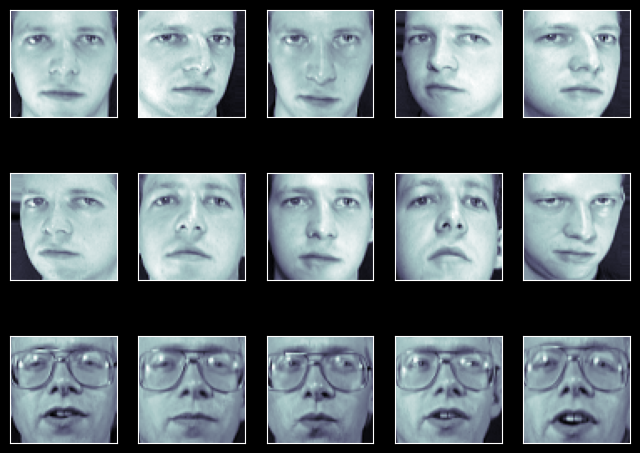

In [5]:
# 샘플 이미지 몇 개를 확인해 봅시다.
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(8, 6))
# plot several images
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(faces.images[i], cmap=plt.cm.bone)

Note is that these faces have already been localized and scaled to a common size. 

### 평균 얼굴 (Mean Face)

PCA를 적용하기 전에, 모든 얼굴의 "평균"은 어떻게 생겼는지 확인해 봅시다. 400개 이미지의 픽셀별 평균값입니다.

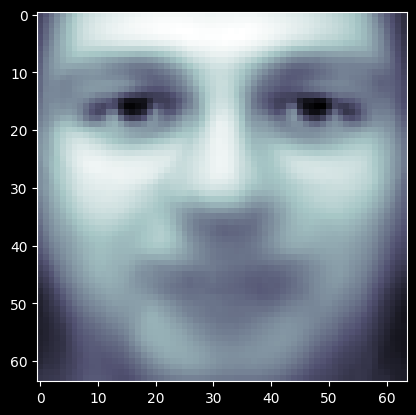

In [6]:
plt.imshow(np.mean(faces.images, axis=0),
           cmap=plt.cm.bone)

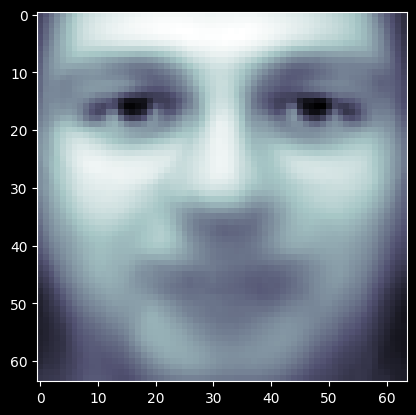

In [7]:
# the same one with the vectorized data
plt.imshow(np.mean(faces.data, axis=0).reshape(64,64),
           cmap=plt.cm.bone)

### PCA 적용 및 결과 분석

`sklearn`의 `PCA`를 사용하여 4096개의 차원($p$)을 400개($n$)의 주성분으로 압축합니다. ($n < p$ 이므로, 최대 주성분 개수는 $n$입니다.)

In [8]:
X = faces.data # n X p matrix (400 x 4096)

# PCA를 사용한 차원 축소
# n_components는 추출할 주성분의 개수입니다.
# n < p (400 < 4096) 이므로, 의미 있는 주성분의 최대 개수는 n=400개입니다.
pca = PCA(n_components=400) 

# PCA의 경우 component 의 수를 크게 정하고 계산 한 뒤 앞의 소수 개를 가져오는 것과, 
# 처음부터 component 의 수를 소수의 개수로 정하고 계산한 것의 결과는 같습니다.

X_pca_transformer = pca.fit(X) # PCA 모델 학습

# PC_Scores: 원본 X 데이터를 새로운 주성분 축으로 변환(projection)한 값입니다. 
# 이것이 바로 "차원이 축소된" 데이터입니다. (Shape: 400 x 400)
PC_Scores = X_pca_transformer.transform(X)

# var_ratio: 각 주성분(PC)이 원본 데이터의 분산을 얼마나 설명하는지 비율. (Eigenvalue의 비율)
var_ratio = X_pca_transformer.explained_variance_ratio_

# PC_loadings: 주성분 벡터(Eigenvector) 자체. 
# 각 PC가 어떤 픽셀(원본 변수)들의 조합으로 이루어져 있는지 나타냅니다.
# 얼굴 이미지에서는 이 로딩 벡터를 "고유 얼굴(Eigenface)"이라고 부릅니다. (Shape: 400 x 4096)
PC_loadings = X_pca_transformer.components_

### 몇 개의 주성분(PC)을 선택해야 할까?

#### 1. 스크리 도표 (Scree Plot)
각 주성분(PC)이 설명하는 분산의 비율(`var_ratio`)을 시각화합니다. 
보통 초반의 PC 몇 개가 대부분의 분산을 설명하고, 뒤로 갈수록 급격히(Elbow) 줄어듭니다.

Text(0, 0.5, 'Explained Variance Ratio')

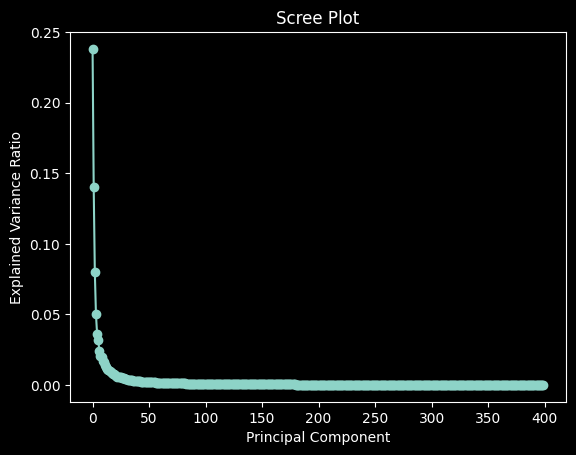

In [9]:
# 각 주성분이 설명하는 분산의 비율
plt.plot(var_ratio,'o-')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')

($\lambda_1$, $\lambda_2$, $\ldots$, $\lambda_K$)

Sum = $\sum_{k=1}^K \lambda_k$

cumsum = ($\lambda_1$, $\lambda_1+\lambda_2$, $\cdots$, $\lambda_1+\cdots+\lambda_K$)
cumsum = [PC1 이 설명하는 분산의 비율, ..., 첫 d-개의 PC가 설명하는 분산의 비율의 합]

#### 2. 누적 설명 분산 (Cumulative Explained Variance)
더 유용한 방법은 '누적' 분산 비율을 보는 것입니다. 
"몇 개의 PC를 사용해야 원본 분산의 90% (또는 95%)를 설명할 수 있는가?"

Text(0, 0.5, 'Cumulative Explained Variance Ratio')

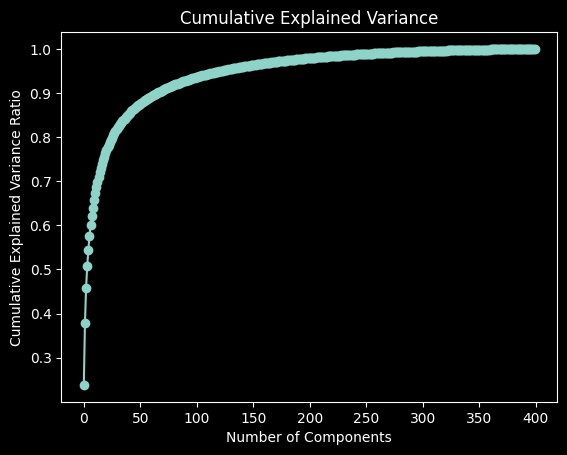

In [10]:
cum_var = np.cumsum(var_ratio)
plt.plot(cum_var, 'o-')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')

약 65개의 주성분이 전체 분산의 90.0%를 설명합니다.


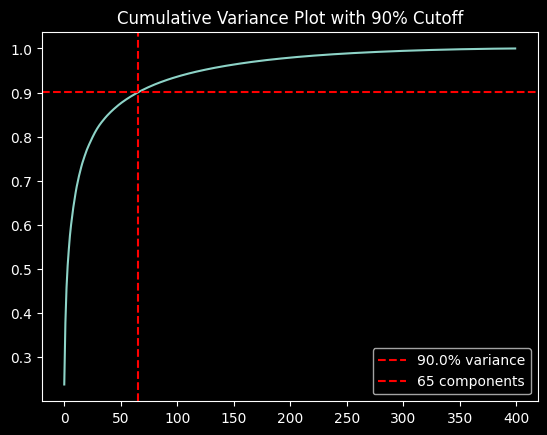

In [11]:
n = X.shape[0] # n<p

# 누적 분산이 90%를 처음 넘는 지점 찾기
component_90 = np.arange(400)[cum_var > 0.9][0]
variance_90 = cum_var[component_90]

print(f"약 {component_90}개의 주성분이 전체 분산의 {variance_90*100:.1f}%를 설명합니다.")

plt.plot(cum_var)
plt.title('Cumulative Variance Plot with 90% Cutoff')
plt.axhline(y = variance_90, color = 'r', linestyle = '--', label = f'{variance_90*100:.1f}% variance')
plt.axvline(x = component_90, color = 'r', linestyle = '--', label = f'{component_90} components')
plt.legend()

**분석**: 4096개의 픽셀 변수를 단 **약 50~60개**의 주성분(PC)만으로도 원본 얼굴 데이터의 변동성을 90% 이상 설명할 수 있습니다. 엄청난 압축입니다!

## 이미지 복원 (Image Reconstruction)

차원 축소의 백미는 '복원'입니다. $k$개의 주성분만 사용해서 원본 이미지를 얼마나 잘 복원할 수 있는지 확인해 봅시다.

PCA는 기본적으로 데이터를 평균($\mu$)으로 중앙화(centering)한 후 변환합니다. 
$X_{centered} = X - \mu$

축소된 데이터(PC Scores)는 다음과 같습니다. (여기서 $L$은 로딩(Eigenfaces) 행렬)
$PC\_Scores = X_{centered} \cdot L^T$

따라서 $d$개의 주성분만 사용하여 복원하는 공식은 다음과 같습니다.

$X_{reconstructed} = (PC\_Scores[:, :d] \text{ @ } PC\_Loadings[:d, :]) + \mu$

(참고: `sklearn`의 PCA는 `inverse_transform` 메소드를 제공하지만, SVD를 이용한 위 계산은 내부 원리를 이해하는 데 도움이 됩니다.)

PCA 의 Inverse transformation 의 경우 ``sklearn`` package 에서 제공을 하나 축소된 차원이 다를 경우 계속 fitting 해야 하는 문제가 있음.

SVD를 이용한 계산에 의하면 다음과 같이 계산될 수 있다.

In [12]:
mean_face = np.mean(faces.data, axis=0)
dim = 5 # 4096차원을 단 5차원으로 압축!

# X_reconst = (PC 점수) @ (PC 로딩) + (원본 평균)
reconst = PC_Scores[:,:dim] @ (PC_loadings[:dim,:]) + mean_face.T

print("Reduced PC Scores (압축된 데이터): ", PC_Scores[:,:dim].shape)
print("Recovered in the original space (복원된 데이터): ", reconst.shape)

Reduced PC Scores (압축된 데이터):  (400, 5)
Recovered in the original space (복원된 데이터):  (400, 4096)


In [13]:
# 첫 번째 이미지의 5차원 PC 점수
PC_Scores[0,:dim]

array([ 6.4326897,  0.7036667, -1.4300088,  1.2785287, -2.5643923],
      dtype=float32)

단 5개의 숫자만으로 첫 번째 얼굴의 특징을 요약했습니다. 이 5개의 숫자로 이미지를 복원해 봅시다.

Text(0.5, 1.0, 'Reconstructed (d=5)')

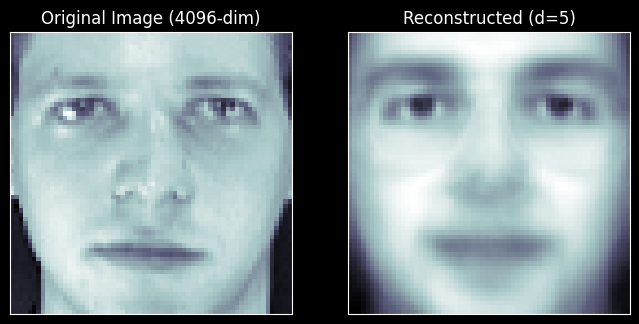

In [14]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.imshow(faces.images[0],  cmap=plt.cm.bone)
ax.set_title("Original Image (4096-dim)")

ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.imshow(reconst[0,:].reshape(64,64),  cmap=plt.cm.bone)
ax.set_title(f"Reconstructed (d={dim})")

차원축소 규모를 조정해보자

주성분 개수($d$)를 늘려가면서 이미지가 어떻게 더 선명하게 복원되는지 확인해 봅시다.

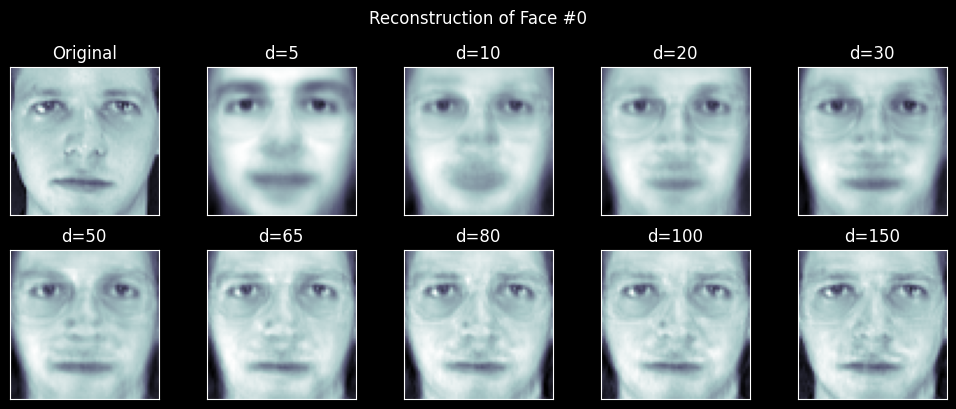

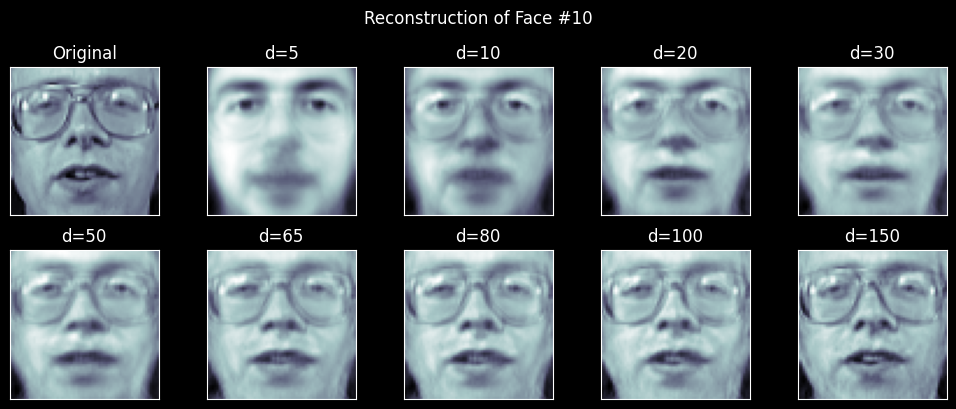

In [15]:
dgrid = np.array([5,10,20,30,50,65,80,100,150])
ngrid = dgrid.shape[0]

k=0 # 첫 번째 사진 (k=0)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(3,5, 1, xticks=[], yticks=[])
ax.imshow(faces.images[k],  cmap=plt.cm.bone)
ax.set_title("Original")
for i in range(ngrid):
    d = dgrid[i]
    reconst =PC_Scores[:,:d] @ (PC_loadings[:d,:]) + mean_face
    ax = fig.add_subplot(3,5, i+2, xticks=[], yticks=[])
    ax.imshow(reconst[k,:].reshape(64,64),  cmap=plt.cm.bone)
    ax.set_title("d="+str(d))
fig.suptitle(f"Reconstruction of Face #{k}")
plt.tight_layout()
    
k=10 # 열한 번째 사진 (k=10)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(3,5, 1, xticks=[], yticks=[])
ax.imshow(faces.images[k],  cmap=plt.cm.bone)
ax.set_title("Original")
for i in range(ngrid):
    d = dgrid[i]
    reconst = PC_Scores[:,:d] @ (PC_loadings[:d,:]) + mean_face
    ax = fig.add_subplot(3,5, i+2, xticks=[], yticks=[])
    ax.imshow(reconst[k,:].reshape(64,64),  cmap=plt.cm.bone)
    ax.set_title("d="+str(d))
fig.suptitle(f"Reconstruction of Face #{k}")
plt.tight_layout()

**분석**: 주성분 개수($d$)가 늘어날수록, 복원된 이미지가 원본과 매우 유사해지는 것을 볼 수 있습니다. $d=150$ 정도가 되면 거의 구분이 불가능할 정도입니다. 이는 PCA가 이미지 압축 및 노이즈 제거에 효과적임을 보여줍니다.

---

# Part 2: 시각화를 위한 비선형 차원 축소 (t-SNE, UMAP)

PCA는 선형(linear) 변환입니다. 즉, 데이터를 회전시키는 것과 같습니다. 
하지만 데이터가 복잡한 비선형 구조(예: 나선형, 스위스 롤)를 가질 경우, PCA는 데이터를 잘 분리하지 못합니다.

t-SNE(t-distributed Stochastic Neighbor Embedding)와 UMAP (Uniform Manifold Approximation and Projection)은 **시각화**를 목적으로 널리 사용되는 비선형 차원 축소 기법입니다.

**핵심 아이디어**: 고차원 공간에서 '가까웠던' 이웃 샘플들이, 저차원(2D 또는 3D) 공간에서도 '가깝게' 유지되도록 데이터를 배치합니다. (지역적 구조 보존)

---

## 예제 2: MNIST 손글씨 숫자

손글씨 숫자(0~9) 데이터셋을 사용합니다. 각 이미지는 8x8 = 64 픽셀입니다. 
64차원 공간에 흩어져 있는 10개의 숫자 클러스터를 2차원 공간으로 가져와서 시각화해 봅시다.

In [16]:
from sklearn.datasets import load_digits

# load the data
digits = load_digits()
X = digits.data # (1797, 64)
y = digits.target # (1797,) - 0~9 레이블
n = X.shape[0]
print(f"Data shape: {X.shape}")

Data shape: (1797, 64)


In [17]:
# 데이터 정규화 (Standard Scaling)
# PCA는 스케일에 민감하지만, t-SNE/UMAP은 덜 민감합니다. 
# 하지만 PCA와 공정한 비교를 위해 모두 스케일링을 적용합니다.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


### 3가지 방법 비교: PCA vs. t-SNE vs. UMAP

64차원의 데이터를 2차원으로 압축하여 10개의 숫자 클러스터(색상)가 잘 분리되는지 비교해 봅시다.

In [18]:
# 1. PCA (n_components=2)
print("Running PCA...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 2. t-SNE (n_components=2)
# t-SNE는 계산량이 많아 시간이 다소 걸릴 수 있습니다.
# perplexity: "이웃"의 개수를 정하는 파라미터. 보통 5~50 사이 값을 사용.
print("Running t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, random_state=1, n_jobs=-1)
X_tsne = tsne.fit_transform(X_scaled)

# 3. UMAP (n_components=2)
# n_neighbors: t-SNE의 perplexity와 유사. 지역적/전역적 구조의 균형을 맞춤.
print("Running UMAP...")
reducer = umap.UMAP(n_neighbors=15, n_components=2, n_jobs=-1)
X_umap = reducer.fit_transform(X_scaled)

print("All reductions complete.")

Running PCA...
Running t-SNE...
Running UMAP...
All reductions complete.


/var/folders/wg/2hx7hs9173z96lq9jg780d840000gn/T/ipykernel_7058/1428100042.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', 10)


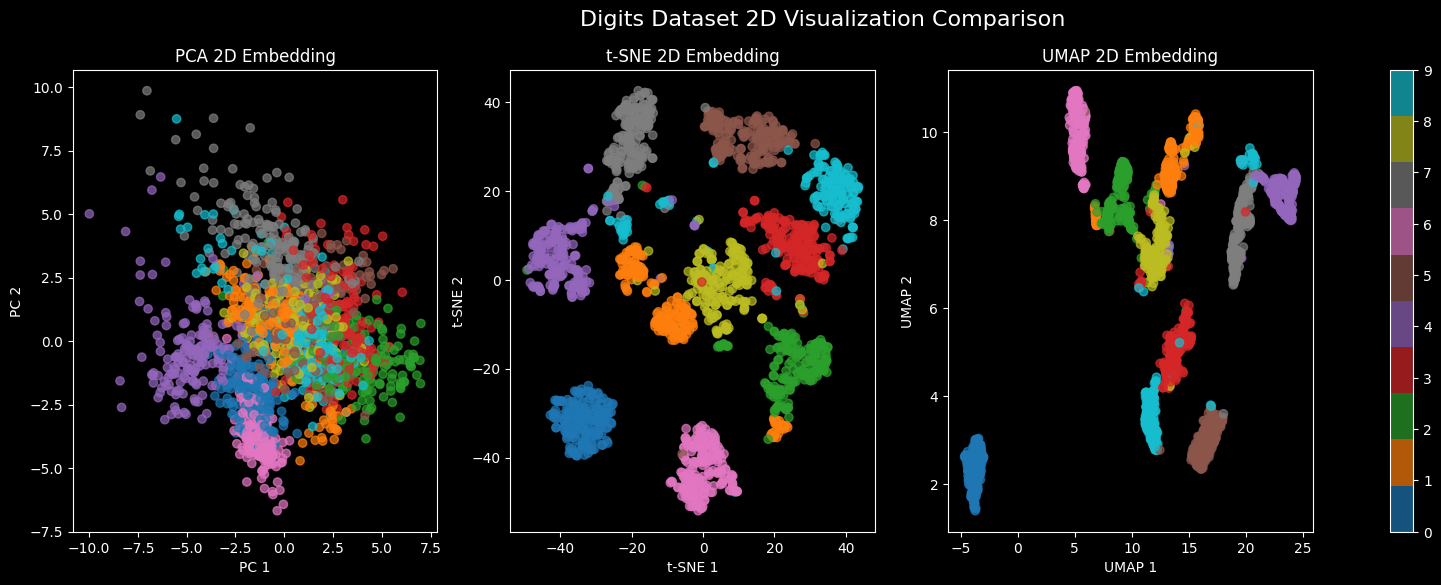

In [19]:
# 시각화
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
cmap = plt.cm.get_cmap('tab10', 10)

# PCA 결과 시각화
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=cmap, alpha=0.7)
ax1.set_title('PCA 2D Embedding')
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')

# t-SNE 결과 시각화
scatter2 = ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap=cmap, alpha=0.7)
ax2.set_title('t-SNE 2D Embedding')
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')

# UMAP 결과 시각화
scatter3 = ax3.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap=cmap, alpha=0.7)
ax3.set_title('UMAP 2D Embedding')
ax3.set_xlabel('UMAP 1')
ax3.set_ylabel('UMAP 2')

# 공통 컬러바 추가
fig.colorbar(scatter1, ax=[ax1, ax2, ax3], ticks=range(10))
plt.suptitle('Digits Dataset 2D Visualization Comparison', fontsize=16)
plt.show()

**분석 결과**

* **PCA**: 선형 방식인 PCA는 10개의 숫자 클러스터를 2차원으로 잘 분리하지 못합니다. 많은 클러스터(예: 1, 9, 7)가 서로 겹쳐져 있습니다. 이는 손글씨 숫자의 '모양'이라는 특징이 선형적이지 않다는 것을 의미합니다.
* **t-SNE**: 비선형 방식인 t-SNE는 10개의 클러스터를 매우 명확하게 분리해냅니다. 같은 숫자는 강하게 뭉치고, 다른 숫자는 멀리 떨어뜨려 놓습니다. 시각화를 통한 클러스터링 확인에 매우 강력합니다.
* **UMAP**: t-SNE와 마찬가지로 클러스터를 훌륭하게 분리합니다.

> **결론**: 시각화를 통해 데이터의 클러스터 구조를 파악하는 것이 목적이라면, PCA보다 **t-SNE**나 **UMAP**이 훨씬 더 적합합니다. 차원축소 이후의 해석이나 축소된 변수를 기반으로 새로운 모델에 적합하려는 경우 통계적인 방법론을 권장합니다.

---

# Part 3: Kernel PCA (KPCA)

**Kernel PCA (KPCA)**는 PCA를 비선형으로 확장한 버전입니다.

**핵심 아이디어**: "커널 트릭(Kernel Trick)" (Support Vector Machine에서 사용하는 것과 동일)을 사용하여, 원본 데이터를 더 높은 차원의 '특성 공간(feature space)'으로 암묵적으로 매핑(mapping)합니다. 
그렇게 매핑된 고차원 공간에서 **선형 PCA**를 수행합니다.

**결과**: 원본 공간에서는 비선형이던 데이터의 구조가, 커널에 의해 매핑된 고차원 공간에서는 선형적으로 분리될 수 있습니다.

KPCA는 t-SNE/UMAP과는 달리 '시각화'가 주 목적이 아니라, 비선형적인 특징을 '추출'하여 **새로운 변수**를 만드는 것이 주 목적입니다. (압축/복원도 가능하지만 PCA보다 복잡합니다.)

---

## 예제 3: 두 개의 달 (make_moons)

KPCA의 위력을 확인하기 위해, 선형적으로는 절대 분리할 수 없는 '두 개의 달' 모양 데이터셋을 사용해 봅시다.

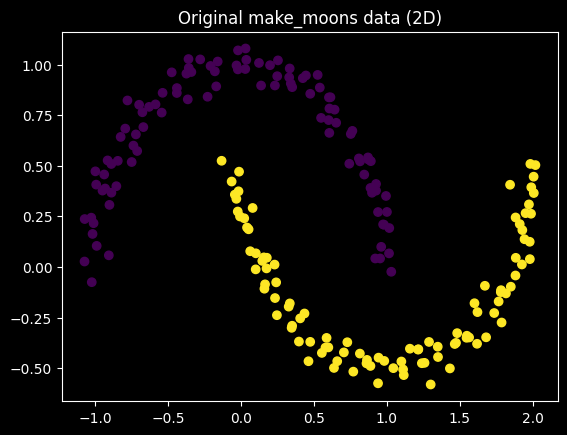

In [20]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=200, noise=0.05, random_state=0)

plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap='viridis')
plt.title('Original make_moons data (2D)')
plt.show()

In [21]:
# 1. 일반 PCA (선형)
pca_moons = PCA(n_components=2)
X_pca_moons = pca_moons.fit_transform(X_moons)

# 2. Kernel PCA (비선형)
# 'rbf' (Radial Basis Function) 커널을 사용합니다.
# gamma: 커널의 영향력 범위. 이 값에 따라 결과가 민감하게 변합니다.
kpca_moons = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_kpca_moons = kpca_moons.fit_transform(X_moons)

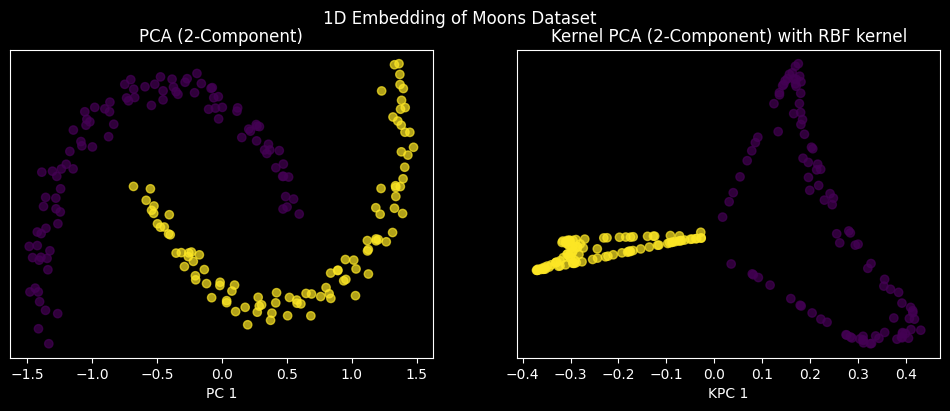

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
zeros = np.zeros_like(X_pca_moons) # y축은 0으로 고정

# PCA (1D)
ax1.scatter(X_pca_moons[:,0], X_pca_moons[:,1], c=y_moons, cmap='viridis', alpha=0.7)
ax1.set_title('PCA (2-Component)')
ax1.set_xlabel('PC 1')
ax1.set_yticks([])

# Kernel PCA (1D)
ax2.scatter(X_kpca_moons[:,0], X_kpca_moons[:,1], c=y_moons, cmap='viridis', alpha=0.7)
ax2.set_title('Kernel PCA (2-Component) with RBF kernel')
ax2.set_xlabel('KPC 1')
ax2.set_yticks([])

plt.suptitle('1D Embedding of Moons Dataset')
plt.show()

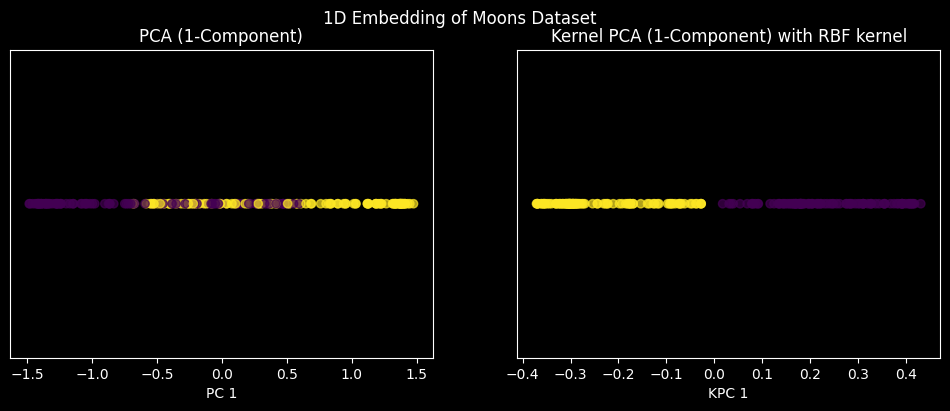

In [23]:
# 1차원으로 압축된 결과를 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
pc1 = X_pca_moons[:,0]
zeros = np.zeros_like(pc1) # y축은 0으로 고정
# PCA (1D)
ax1.scatter(pc1, zeros, c=y_moons, cmap='viridis', alpha=0.7)
ax1.set_title('PCA (1-Component)')
ax1.set_xlabel('PC 1')
ax1.set_yticks([])

# Kernel PCA (1D)
kpc1 = X_kpca_moons[:,0]
ax2.scatter(kpc1, zeros, c=y_moons, cmap='viridis', alpha=0.7)
ax2.set_title('Kernel PCA (1-Component) with RBF kernel')
ax2.set_xlabel('KPC 1')
ax2.set_yticks([])

plt.suptitle('1D Embedding of Moons Dataset')
plt.show()

KPCA: Hyperparameter $\gamma$ 에 따른 성능 변화

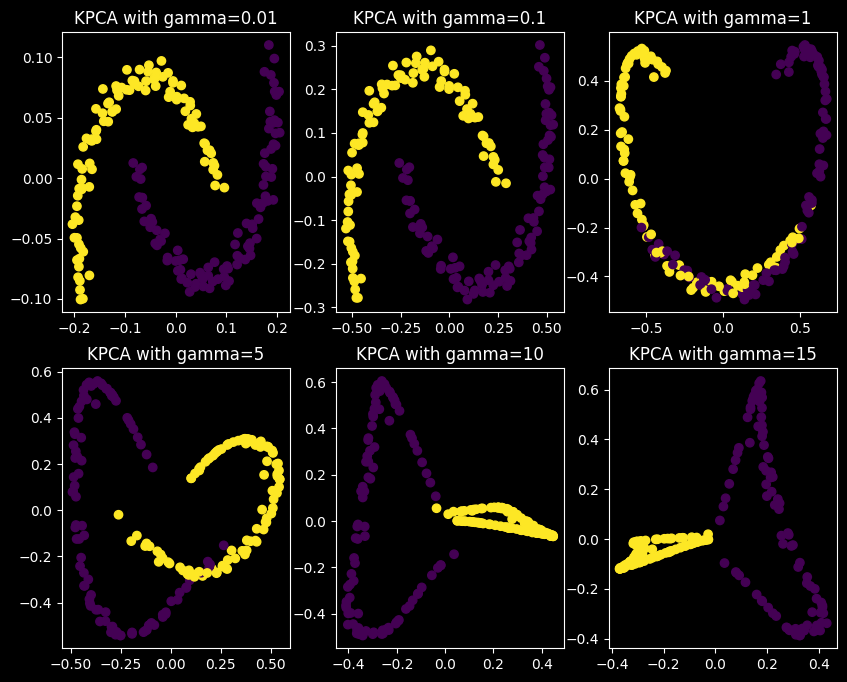

In [24]:
gamma_grid = [0.01, 0.1, 1, 5, 10, 15]
fig = plt.figure(figsize=(10, 8))
# plot several images
for i in range(6):
    gamma = gamma_grid[i]
    kpca_moons = KernelPCA(n_components=2, kernel='rbf', gamma=gamma)
    X_kpca_moons = kpca_moons.fit_transform(X_moons)
    ax = fig.add_subplot(2,3,i+1)
    ax.scatter(X_kpca_moons[:, 0], X_kpca_moons[:, 1], c = y_moons)
    ax.title.set_text('KPCA with gamma='+str(gamma))

**분석 결과**

* **PCA**: 선형 PCA는 데이터를 1차원으로 투영(projection)할 뿐이므로, 두 개의 달(노란색/보라색) 클러스터가 1차원 축 상에서 완전히 겹쳐버렸습니다. 이 1D 데이터로는 두 클래스를 분류할 수 없습니다.
* **Kernel PCA**: RBF 커널을 사용한 KPCA는 비선형 구조를 '펼쳐서' 1차원으로 압축했습니다. 그 결과, 두 클러스터가 1차원 축 상에서 거의 완벽하게 분리되었습니다. 이 1D 데이터(KPC 1)는 두 클래스를 분류하는 매우 강력한 하나의 변수(feature)가 됩니다.